# Krok 0: Načtení dat

Použijeme [dataset filmů dostupný na Kaggle](https://www.kaggle.com/datasets/utkarshx27/movies-dataset), který obsahuje více než 4800 záznamů s následujícími sloupci:

| Name |	Description  |
| ----- | ----- |
|index 	|The index of the dataframe |
|budget 	|The budget of the movie |
|genres 	|The genres of the movie |
|homepage 	|The homepage URL of the movie |
|id 	|The unique identifier of the movie |
|keywords 	|The keywords associated with the movie |
|original_language 	|The original language of the movie |
|original_title 	|The original title of the movie|
|overview 	|A brief overview or summary of the movie|
|popularity 	|The popularity score of the movie|
|production_companies 	|The production companies involved in making the movie |
|production_countries 	|The countries where the movie was produced |
|release_date 	|The release date of the movie |
|revenue 	|The revenue generated by the movie |
|runtime 	|The duration of the movie in minutes |
|spoken_languages 	|The languages spoken in the movie |
|status 	|The status of the movie (e.g., Released, Rumored) |
|tagline 	|The tagline or slogan of the movie |
|title 	|The title of the movie |
|vote_average 	|The average rating given to the movie by users |
|vote_count 	|The number of votes received by the movie 	|
|cast 	|The cast members of the movie |
|crew 	|The crew members involved in making the movie |
|director| 	The director of the movie |

Zahrneme pouze filmy s počtem hlasů větším než 5, abychom zajistili, že jejich hodnocení jsou dostatečně reprezentativní. Kromě toho se zdá, že dataset je neúplný pro filmy vydané v roce 2016 a později, takže omezíme naši analýzu na filmy vydané do roku 2015.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the CSV file into a DataFrame
df = pd.read_csv('movie_dataset.csv')

# Data Cleaning and Preprocessing
# Convert 'release_date' to just a year
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

df = df[df['budget'] > 0]

# Drop rows with missing values in important columns
df.dropna(subset=['budget', 'revenue', 'release_year', 'runtime'], inplace=True)

# Add profit column
df['profit'] = df['revenue'] - df['budget']

df = df[df['vote_count'] >= 5]
df = df[df['release_year'] <= 2015]

FIGURE_SIZE = (10, 6)

# Krok 1: Zkoumání dat

Podívejme se blíže na data. Co z nich můžeme vyvodit?

#### Distribuce rozpočtů filmů

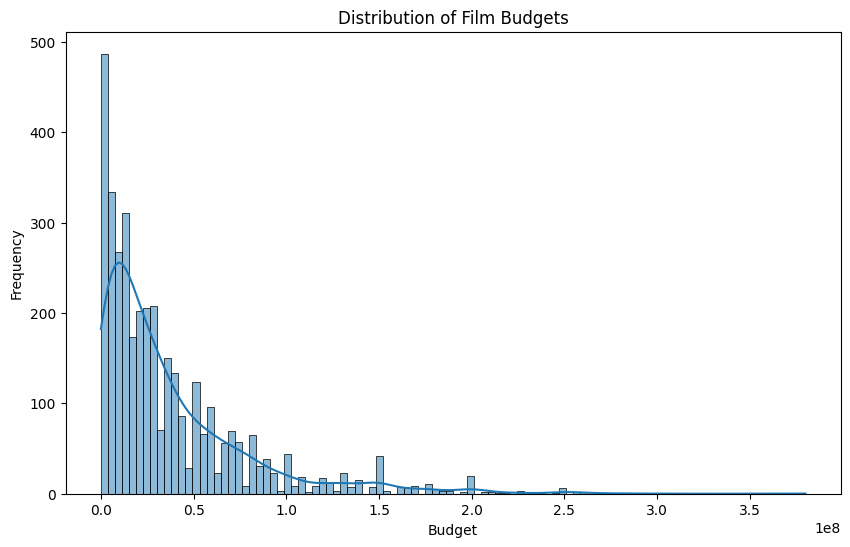

In [3]:
# 1. Distribution of Film Budgets
plt.figure(figsize=FIGURE_SIZE)
sns.histplot(df['budget'], bins=100, kde=True)
plt.title('Distribution of Film Budgets')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

Pomocí [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) můžeme vidět, že distribuce rozpočtů filmů je pravostranně zešikmená: existuje mnoho nízkorozpočtových filmů a pak prudký pokles.

#### Příjmy (a znovu rozpočet)

Podívejme se, které filmy jsou nejvýdělečnější podle příjmů. Pak se podíváme, jak rozpočet ovlivňuje příjmy.

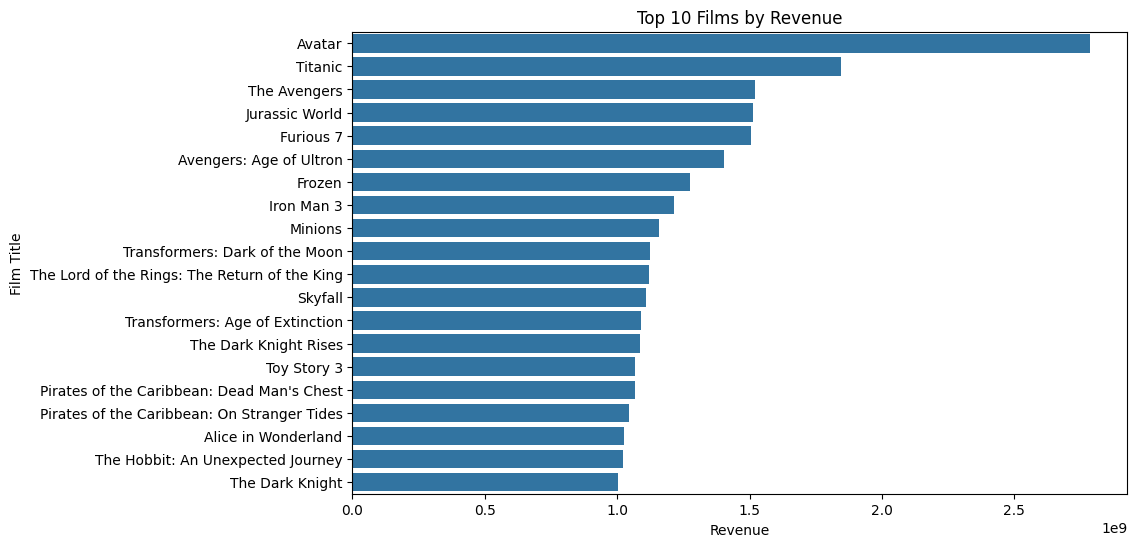

In [4]:
# 2. Top 10 Films by Revenue
top_revenue = df.nlargest(20, 'revenue')
plt.figure(figsize=FIGURE_SIZE)
sns.barplot(x='revenue', y='title', data=top_revenue)
plt.title('Top 10 Films by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Film Title')
plt.show()

Vidíme to, co bychom očekávali: jsou to dobře známé filmy, o kterých téměř každý slyšel, což není překvapivé. Nyní vyvstává zajímavá otázka: ovlivňuje rozpočet příjmy? Lze koupit úspěch filmu?

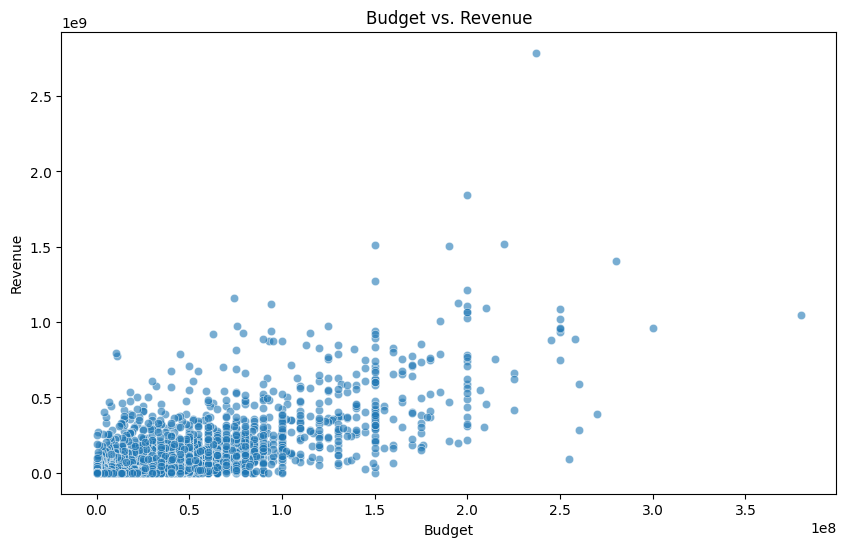

In [5]:
plt.figure(figsize=FIGURE_SIZE)
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.6)
plt.title('Budget vs. Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

Z tohoto grafu můžeme vyvodit dva klíčové poznatky:

1. Většina filmů není zisková, protože se nachází pod přímkou y=x, což znamená, že jejich příjmy jsou nižší než náklady na produkci.
2. Je patrná korelace mezi rozpočtem a příjmy (jak je dále ilustrováno korelační tepelnou mapou níže). Vidíme však, že korelace není dostatečně silná, takže vyšší rozpočty často zvyšují riziko finanční ztráty.

#### Změnila se délka filmů v průběhu desetiletí? A je zde změna v objemu produkce?

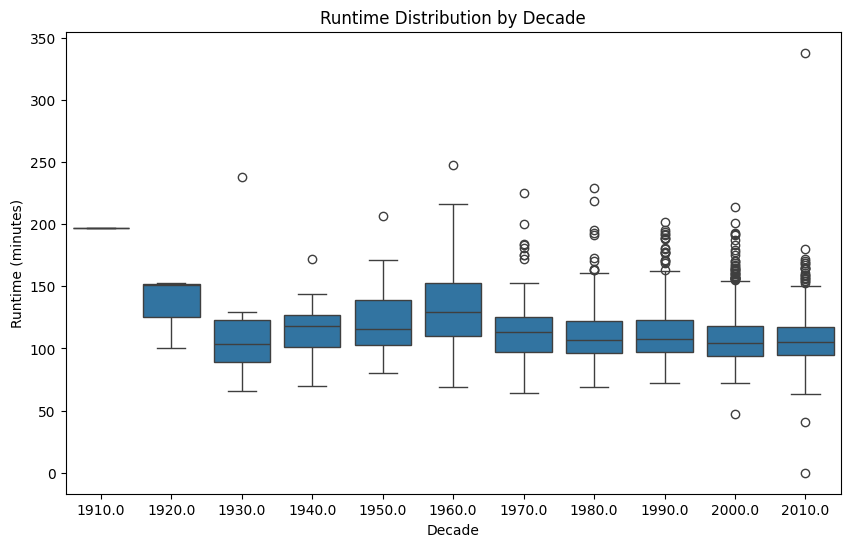

In [6]:
df['decade'] = (df['release_year'] // 10) * 10
plt.figure(figsize=FIGURE_SIZE)
sns.boxplot(x='decade', y='runtime', data=df)
plt.title('Runtime Distribution by Decade')
plt.xlabel('Decade')
plt.ylabel('Runtime (minutes)')
plt.show()

Zdá se, že během rané éry filmového průmyslu v první polovině 20. století filmaři experimentovali s různými délkami filmů. Nicméně, jak jsme se blížili k 21. století, délky filmů se ustálily na standardním rozmezí 100-150 minut, s několika pravidelnými výjimkami, které obvykle toto rozmezí překračují.

A co objem produkce?

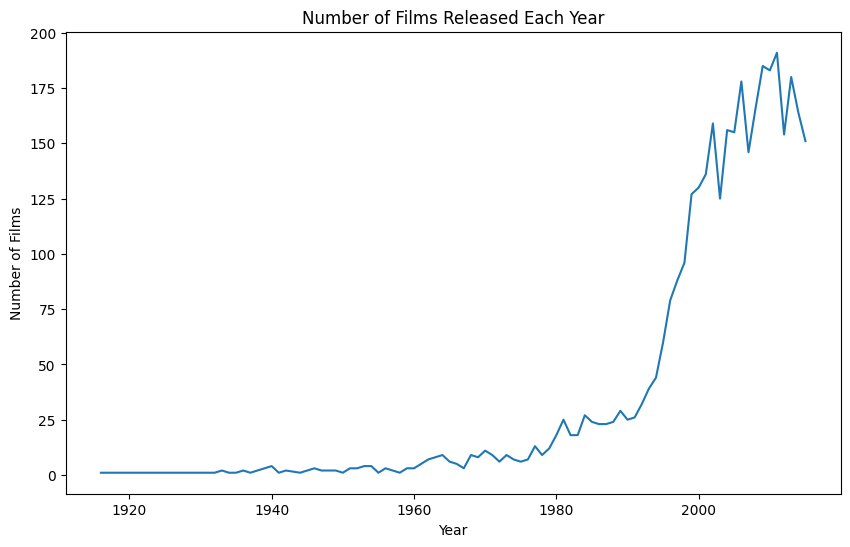

In [7]:
films_per_year = df['release_year'].value_counts().sort_index()
plt.figure(figsize=FIGURE_SIZE)
sns.lineplot(x=films_per_year.index, y=films_per_year.values)
plt.title('Number of Films Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.show()

#### Popularita filmů

Nyní bychom se rádi podívali na to, jak příjmy, rozpočet a žánr ovlivňují popularitu filmu mezi širokou veřejností a kritiky. Podívejme se na filmy s nejvyšším průměrným hodnocením.

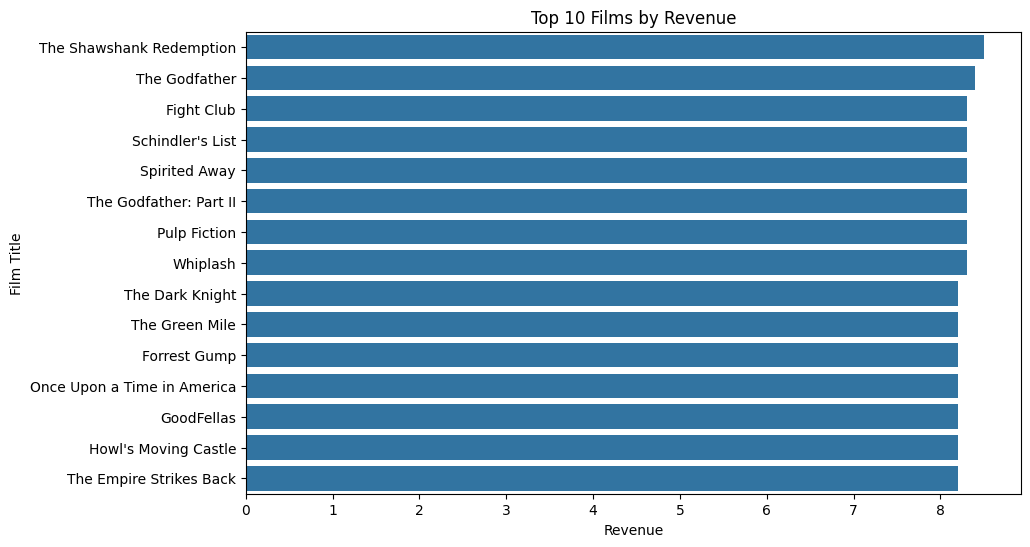

In [8]:
top_revenue = df.nlargest(15, 'vote_average')
plt.figure(figsize=FIGURE_SIZE)
sns.barplot(x='vote_average', y='title', data=top_revenue)
plt.title('Top 10 Films by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Film Title')
plt.show()

Opět zde nejsou žádná překvapení: většinu těchto filmů dobře známe, často je považujeme za úžasné a dobře provedené. A co průměrné hodnocení podle žánru?

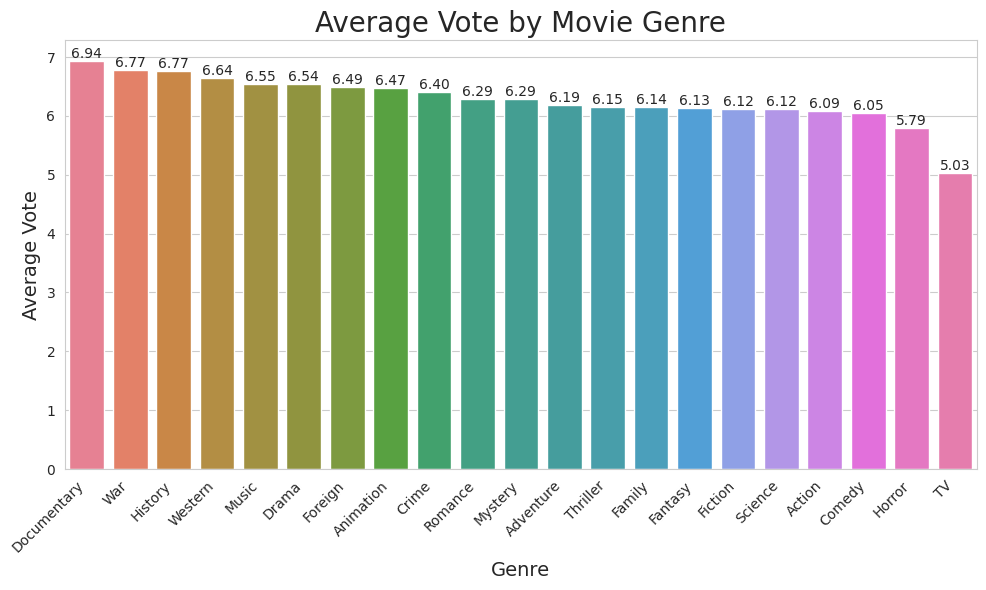

In [9]:
INVALID_GENRES = ["Movie", "nan"]

def get_accumulated_votes_and_genre_counter(df):
    genres_and_votes = [(str(genres).split(), vote) for genres, vote in df[['genres', 'vote_average']].values]
    counter = defaultdict(int)
    accumulated_votes = defaultdict(int)
    for genres, vote in genres_and_votes:
        for genre in genres:
            if genre in INVALID_GENRES:
                continue
            counter[genre] += 1
            accumulated_votes[genre] += vote

    return accumulated_votes, counter

def normalize_votes(accumulated_votes_counter_tuple):
    accumulated_votes, counter = accumulated_votes_counter_tuple
    return {genre: votes / counter[genre] for genre, votes in accumulated_votes.items()}

def build_plot(data):
    df_votes = pd.DataFrame.from_dict(data, orient='index', columns=['Average Vote'])
    df_votes.reset_index(inplace=True)
    df_votes.columns = ['Genre', 'Average Vote']

    df_votes = df_votes.sort_values('Average Vote', ascending=False)

    plt.figure(figsize=FIGURE_SIZE)
    sns.set_style("whitegrid")

    ax = sns.barplot(x='Genre', y='Average Vote', hue='Genre', data=df_votes, legend=False)
    plt.title('Average Vote by Movie Genre', fontsize=20)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel('Average Vote', fontsize=14)

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    for i, v in enumerate(df_votes['Average Vote']):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

    return plt

average_vote_by_genre = normalize_votes(get_accumulated_votes_and_genre_counter(df))
plt = build_plot(average_vote_by_genre)
plt.show()


Jak můžeme vidět, dokumenty mají nejvyšší průměrné hodnocení, následované válečnými, historickými a westernovými žánry. Spekuluji, že je to proto, že dokumenty jsou obvykle vysoké nebo střední kvality a zřídka vidíme špatně natočené dokumenty. Toto pozorování zahrnuje nejen dokumentární žánr, ale také historické a válečné filmy. V důsledku toho není mnoho nízko kvalitních filmů, které by snižovaly průměrné hodnocení.

Na druhou stranu je překvapivé, že akční, komediální a dobrodružné žánry jsou na nižším konci stupnice. Očekával jsem, že budou výše, protože většina nejpopulárnějších filmů patří do těchto žánrů. Věřím, že je to proto, že na rozdíl od dokumentů jsou fantasy, dobrodružné a akční filmy populárnější a přitahují méně zkušené producenty, kteří vytvářejí nízko kvalitní filmy, čímž snižují průměrné hodnocení.

Nyní vypočítejme korelační tepelnou mapu mezi rozpočtem, příjmy, popularitou a průměrným hodnocením, abychom viděli, jak se různé vlastnosti navzájem ovlivňují.

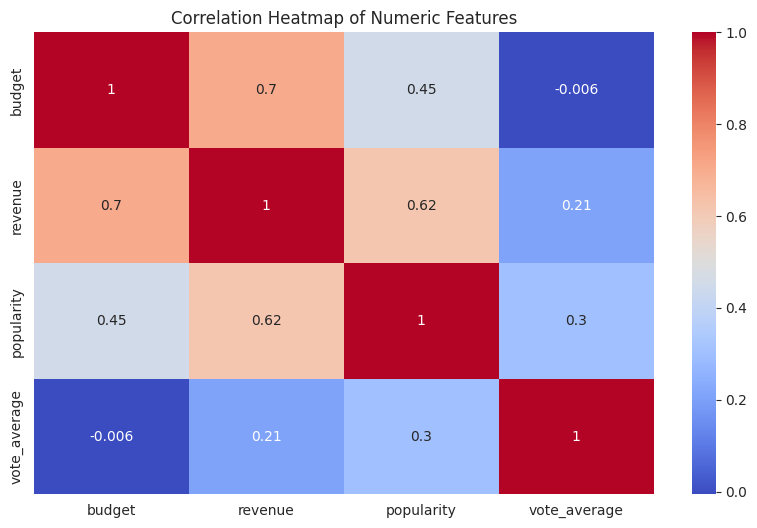

In [10]:
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average',]
correlation = df[numeric_cols].corr()
plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

Z tohoto grafu můžeme vyvodit několik poznatků:

1. Jak jsme naznačili dříve, zdá se, že existuje korelace mezi rozpočtem a příjmy. Je však obtížné rozlišit mezi korelací a kauzalitou. Je pravděpodobné, že oba jsou ovlivněny faktory, jako je reputace režiséra: zavedení režiséři jako Christopher Nolan mohou přilákat více financování a pozornosti, což vede k vyšším rozpočtům a příjmům jejich filmů. Na druhou stranu, samotný rozpočet jistě může zvýšit celkové příjmy, stačí vzít v úvahu vyšší možné marketingové výdaje.

2. Zdá se, že neexistuje korelace mezi rozpočtem a průměrným hodnocením voličů (vote average), což naznačuje, že úspěch filmu nelze jednoduše koupit. Alternativně by to mohlo znamenat, že vyšší rozpočty přinášejí vyšší očekávání, která mohou potenciální výhody vyvážit (to znamená, že vysoký rozpočet se ruší s vysokým očekáváním).

3. Existuje znatelná korelace mezi popularitou a rozpočtem. Filmy s vyššími rozpočty mají tendenci generovat větší rozruch, potenciálně v důsledku zvýšeného marketingového úsilí.

# Krok 2: Intervalové odhady a testování hypotéz

Udělejme nějaké intervalové odhady, abychom se o datech dozvěděli více. Můžeme například spolehlivě odhadnout, jaká je délka filmu? Nebo jaký rozpočet film pravděpodobně bude mít? Nebo jak ziskové filmy jsou?

In [3]:
import numpy as np
from scipy import stats

ALPHA = 0.05

def calculate_ci(data):
    confidence = 1.0 - ALPHA
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=sem)
    return mean, ci

runtime_mean, runtime_ci = calculate_ci(df['runtime'].dropna())
budget_mean, budget_ci = calculate_ci(df['budget'].dropna())
vote_mean, vote_ci = calculate_ci(df['vote_average'].dropna())

df['roi'] = (df['revenue'] - df['budget']) / df['budget']
roi_mean, roi_ci = calculate_ci(df['roi'].dropna())

def printIntervalEstimation(title, mean, estimation, measure=""):
    print('='*55)
    print(title)
    print(f"Mean: {mean} {measure}")
    print(f"{int(100*(1.0-ALPHA))}% Confidence Interval: ({estimation[0]:.2f}, {estimation[1]:.2f}) {measure}")

printIntervalEstimation("Average Movie Runtime", runtime_mean, runtime_ci, "minutes")
printIntervalEstimation("Average Movie Budget", budget_mean, budget_ci, "$")
printIntervalEstimation("Average Vote Rating", vote_mean, vote_ci)
printIntervalEstimation("Average Return On Investment (ROI)", roi_mean, roi_ci, "(times)")

Average Movie Runtime
Mean: 109.55970149253731 minutes
95% Confidence Interval: (108.88, 110.24) minutes
Average Movie Budget
Mean: 37183440.876451075 $
95% Confidence Interval: (35810213.53, 38556668.22) $
Average Vote Rating
Mean: 6.262437810945274 
95% Confidence Interval: (6.23, 6.29) 
Average Return On Investment (ROI)
Mean: 2636.043205941254 (times)
95% Confidence Interval: (-2001.79, 7273.87) (times)


Jak můžeme vidět, máme poměrně přesné odhady průměrné délky, rozpočtu a hodnocení hlasů, všechny v úzkém intervalu s 95% úrovní spolehlivosti, což naznačuje vysokou míru přesnosti. Nicméně ROI ukazuje extrémně široký interval spolehlivosti, což naznačuje obrovskou variabilitu. To znamená, že průměr je velmi špatným a v podstatě nepoužitelným odhadem ROI filmu.

Nyní otestujme některé hypotézy. Například by bylo zajímavé otestovat, zda existuje závislost mezi průměrným hodnocením filmu a jeho rozpočtem. Nebo zda jsou anglicky mluvené filmy úspěšnější než filmy v jiných jazycích. Nebo zda žánr ovlivňuje průměrné hodnocení?

In [12]:
H_0 = "There ISN'T significant difference in vote average between high- and low-budget movies"
H_1 = "There IS significant difference in vote average between high- and low-budget movies"

median_budget = df['budget'].median()
high_budget_votes = df[df['budget'] > median_budget]['vote_average']
low_budget_votes = df[df['budget'] <= median_budget]['vote_average']

t_stat, p_value = stats.ttest_ind(high_budget_votes, low_budget_votes)

print("High-budget vs Low-budget Movies Vote Average:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print("Conclusion: ", f"Reject null hypothesis. H_1: {H_1}" if p_value < 0.05 else "Fail to reject null hypothesis.  H_0: {H_0}")

High-budget vs Low-budget Movies Vote Average:
T-statistic: -4.140771242552482
P-value: 3.540447210588408e-05
Conclusion:  Reject null hypothesis. H_1: There IS significant difference in vote average between high- and low-budget movies


Existuje významný rozdíl v průměrném hodnocení mezi vysoko rozpočtovými a nízko rozpočtovými filmy. To znamená, že filmy s většími rozpočty mají tendenci mít vyšší průměrné hodnocení. Tento výsledek není příliš překvapivý, protože více zdrojů umožňuje najmout zkušenější jednotlivce (herce, producenty, režiséry, štáb), investovat více do marketingu a komunikovat s kritiky.

In [13]:
H_0 = "Success of the movies DOES NOT depend on the language. Movies in English are equally likely to succeed with Non-English speaking movies"
H_1 = "Success of the movies DOES depend on the language."

df['is_english'] = df['original_language'] == 'en'
median_revenue = df['revenue'].median()
df['high_revenue'] = df['revenue'] > median_revenue

contingency_table = pd.crosstab(df['is_english'], df['high_revenue'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Relationship between Original Language and Commercial Success")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print("Conclusion: ", f"Reject null hypothesis. H_1: {H_1}" if p_value < 0.05 else f"Fail to reject null hypothesis. H_0: {H_0}")

Relationship between Original Language and Commercial Success
Chi-square statistic: 64.75887446179595
P-value: 8.464752301180012e-16
Conclusion:  Reject null hypothesis. H_1: Success of the movies DOES depend on the language.


Úspěch filmů často závisí na jejich původním jazyce, přičemž anglicky mluvené filmy jsou finančně úspěšnější než filmy v jiných jazycích. To je očekávané z několika důvodů. Za prvé, existuje více mluvčích angličtiny po celém světě, jak rodilých, tak nerodilých. Za druhé, anglicky mluvené filmy jsou často režírovány známými a vysoce kvalifikovanými producenty, což přispívá k jejich vysoké kvalitě a následně vyšším tržbám.

Podívejme se, zda může být úspěch filmu ovlivněn jeho žánrem. Provedeme test hypotézy pro každý žánr, abychom určili: "Je průměrné hodnocení pro [ŽÁNR] vyšší než průměrné hodnocení pro všechny ostatní žánry?"

In [21]:
GENRES = ['Action', 'Adventure', 'Fantasy', 'Science', 'Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', 'TV']

for current_genre in GENRES:
    def is_current_genre(genres):
        if type(genres) == str:
            return current_genre in genres
        return False

    df['is_current_genre'] = df['genres'].apply(is_current_genre)
    median_vote = df['vote_average'].median()
    df['high_vote'] = df['vote_average'] > median_vote

    contingency_table = pd.crosstab(df['is_current_genre'], df['high_vote'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    print(f"Relationship between {current_genre} Genre and Vote Average Success:")
    print(f"Chi-square statistic: {chi2} | P-value: {p_value}")
    print("Result:", f"Reject null hypothesis." if p_value < 0.05 else "Can't reject null hypothesis.")
    print('='*55)

Relationship between Action Genre and Vote Average Success:
Chi-square statistic: 45.33958080386605 | P-value: 1.6566699790323582e-11
Result: Reject null hypothesis.
Relationship between Adventure Genre and Vote Average Success:
Chi-square statistic: 7.086705724551232 | P-value: 0.0077657867439057185
Result: Reject null hypothesis.
Relationship between Fantasy Genre and Vote Average Success:
Chi-square statistic: 4.79242406774449 | P-value: 0.02858517030427365
Result: Reject null hypothesis.
Relationship between Science Genre and Vote Average Success:
Chi-square statistic: 6.668576958963392 | P-value: 0.009812750800396168
Result: Reject null hypothesis.
Relationship between Fiction Genre and Vote Average Success:
Chi-square statistic: 6.668576958963392 | P-value: 0.009812750800396168
Result: Reject null hypothesis.
Relationship between Crime Genre and Vote Average Success:
Chi-square statistic: 2.1596824784669093 | P-value: 0.14167396339869698
Result: Can't reject null hypothesis.
Rela

Získali jsme následující výsledky:

Nemůžeme zamítnout nulovou hypotézu pro žánry Krimi, Romance, Mysteriózní, Zahraniční a TV.

Proto zamítáme $H_0$ pro žánry Akční, Dobrodružný, Fantasy, Sci-Fi, Drama, Thriller, Animovaný, Rodinný, Western, Komedie, Horor, Historický, Válečný, Hudební a Dokumentární.

Abych byl upřímný, tyto výsledky mi nedávají moc smysl. Podezřívám, že testování takových hypotéz by mohlo vyžadovat pokročilejší techniky, které jsme v našem kurzu Pravděpodobnosti a Statistiky neprobírali. Nicméně jedním způsobem, jak interpretovat tyto výsledky, je poznamenat, že žánry Krimi, Romance, Mysteriózní a Zahraniční jsou uprostřed grafu (viz "Průměrné hodnocení podle filmového žánru" výše). Mají "průměrné" průměrné hodnocení, s výjimkou TV. Ostatní žánry nejsou ve středu grafu, což naznačuje, že jejich průměrné hodnocení je ovlivněno jejich žánrem.

# Krok 3: Predikce

Nyní se pokusme udělat nějaké predikce. Bylo by zajímavé otestovat, zda můžeme spolehlivě předpovědět příjmy filmu na základě různých faktorů. Kromě toho bychom mohli prozkoumat předpovídání průměrného hodnocení filmu nebo popularity pomocí podobných faktorů.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def perform_regression(X, y, feature_names, target_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"\nPredicting {target_name}:")
    print(f"Mean Squared Error: {mse}")
    print("Coefficients:")
    for feature, coef in zip(feature_names, model.coef_):
        print(f"  {feature}: {coef}")
    print(f"Intercept: {model.intercept_}")
    
    # Show actual and predicted values
    plt.figure(figsize=FIGURE_SIZE)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f"Actual {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Actual vs Predicted {target_name}")
    plt.tight_layout()
    plt.show()

df_clean = df.dropna(subset=['revenue', 'budget', 'runtime', 'popularity', 'vote_average'])

Je logické zkusit předpovědět příjmy filmu na základě jeho rozpočtu a popularity. Podívejme se, jak dobré jsou naše předpovědi.


Predicting Revenue:
Mean Squared Error: 1.6515020736450732e+16
Coefficients:
  budget: 2.2261518018400097
  runtime: 1793871.9152349054
Intercept: -25961275.258199602


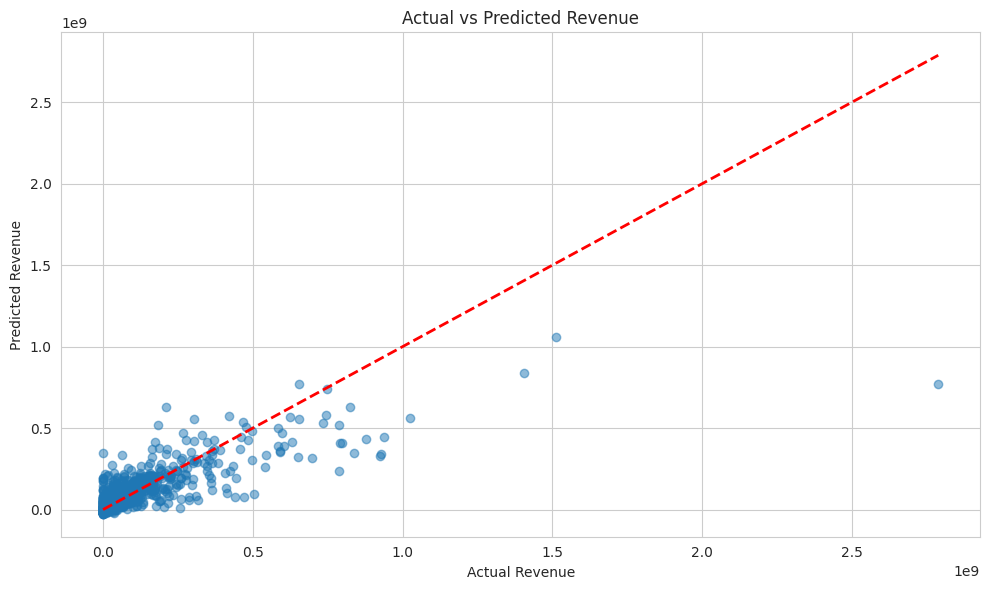

In [26]:
# 1. Predicting revenue
X = df_clean[['budget', 'popularity']]
y = df_clean['revenue']
perform_regression(X, y, ['budget', 'runtime', 'popularity'], 'Revenue')

Jak vidíme, předpovědi se ukázaly být poměrně přesné.


Predicting Vote Average:
Mean Squared Error: 0.651722611812432
Coefficients:
  budget: -3.4935158517809625e-09
  runtime: 0.00968526302036533
Intercept: 6.1475539243610475


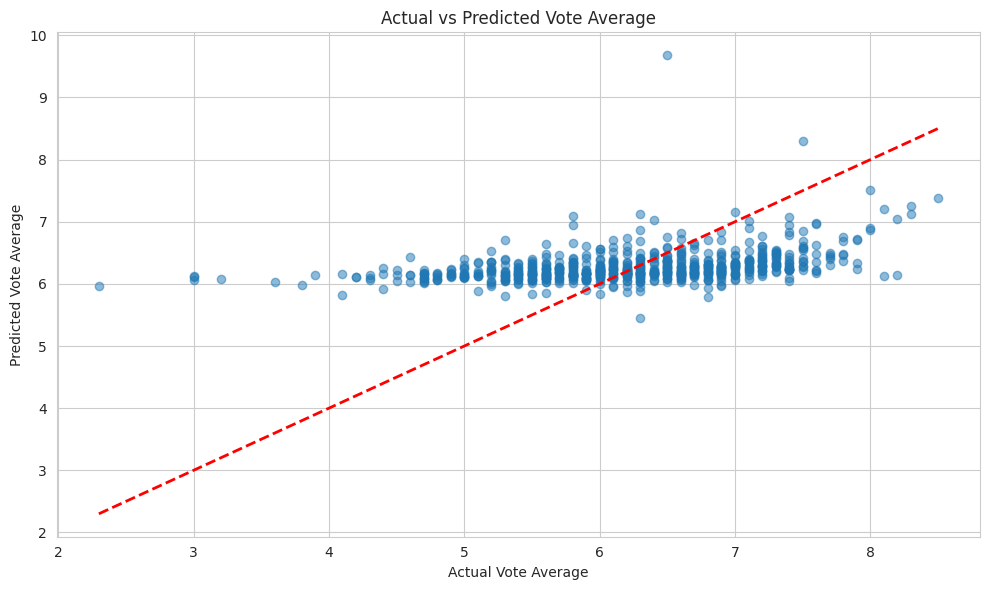

In [27]:
# 2. Predicting vote average
X = df_clean[['budget',  'popularity']]
y = df_clean['vote_average']
perform_regression(X, y, ['budget', 'runtime', 'popularity'], 'Vote Average')

Náš model má tendenci předpovídat průměrné hodnocení přibližně 6. To je očekávané, protože průměrné hodnocení pro všechny žánry je kolem 6, jak jsme pozorovali dříve.


Predicting Popularity:
Mean Squared Error: 493.3488949930414
Coefficients:
  budget: 6.394166303447857e-08
  runtime: 7.422196507570091
  vote_average: 1.019120956513575e-07
Intercept: -33.48764462446087


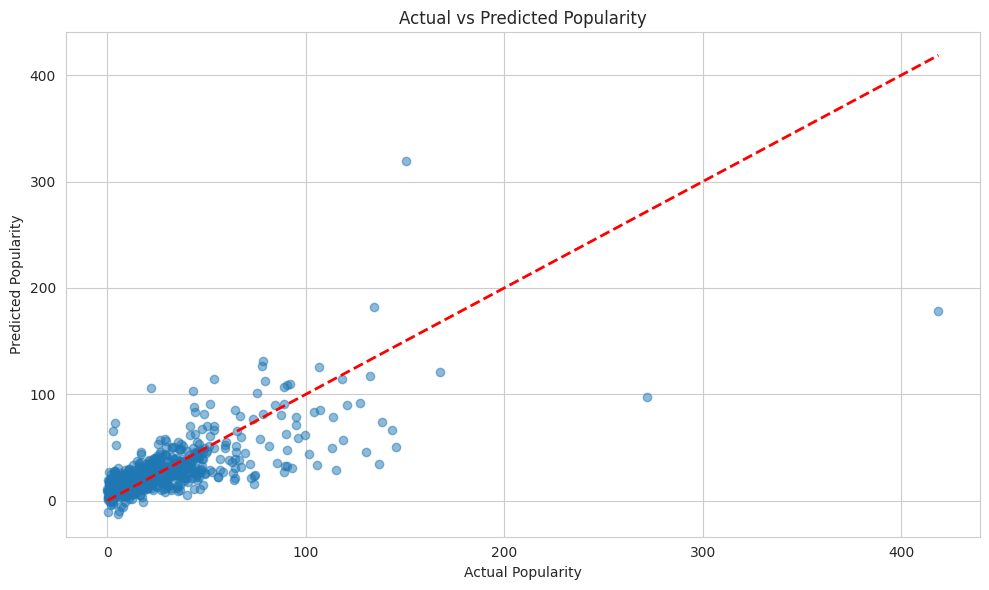

In [31]:
# 3. Predicting popularity
X = df_clean[['budget', 'vote_average', 'revenue']]
y = df_clean['popularity']
perform_regression(X, y, ['budget', 'runtime', 'vote_average'], 'Popularity')

Bodový graf ukazuje, že model poskytuje poměrně přesné předpovědi, zejména pro nižší hodnoty popularity, kde se datové body shlukují těsně kolem červené přerušované čáry (reprezentující perfektní předpovědi). Nicméně, s rostoucí skutečnou popularitou mají předpovědi tendenci více se odchylovat, což naznačuje klesající přesnost modelu pro vysoce populární filmy.